# Multi Tone (Baterai)

Import Library

In [59]:
import numpy as np
import librosa
from scipy.io import wavfile
from IPython.display import Audio
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
import sounddevice as sd
import librosa.display
import pandas as pd

## Pre-processing Audio

Convert audio ke mono dan normalisasi amplitudo

In [60]:
file_audio = "03_battery.wav"

sr, audio = wavfile.read(file_audio)

if audio.dtype == np.uint16:
    audio = audio.astype(np.float32)
    audio = (audio - 32768) / 32768.0

elif audio.dtype == np.int16:
    audio = audio.astype(np.float32) / 32768.0

if len(audio.shape) > 1:
    audio = audio[:, 0]

Audio(audio, rate=sr)

Hasil normalisasi

In [61]:
print(np.min(audio), np.max(audio))
print(audio[:20])

-0.1946106 0.19720459
[0.13653564 0.14562988 0.15353394 0.15997314 0.16531372 0.1696167
 0.17260742 0.17437744 0.1749878  0.174469   0.17276001 0.1696167
 0.16506958 0.15924072 0.15216064 0.1439209  0.13446045 0.12390137
 0.11276245 0.10131836]


Panjang durasi audio dan jumlah sampel sinyal per detiknya

In [62]:
print("Sample Rate:", sr)
print("Durasi Audio:", len(audio)/sr, "detik")

Sample Rate: 48000
Durasi Audio: 0.91 detik


Cek noise pada data audio

In [63]:
# Ambil 10% sampel amplitudo terkecil sebagai noise
portion = int(len(audio) * 0.1)
idx = np.argsort(np.abs(audio))[:portion]
noise_signal = audio[idx]

print("Noise samples:", len(noise_signal))

Noise samples: 4368


Menangani noise pada data audio

Jumlah frame mencurigakan: 3


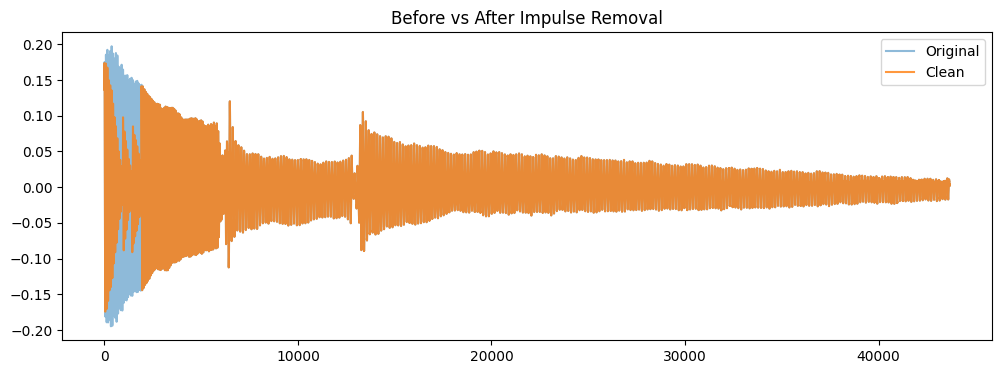

In [64]:
#frame hitung energi
frame = int(0.02 * sr) 
step = frame // 2     
energies = []

for i in range(0, len(audio) - frame, step):
    energies.append(np.sum(audio[i:i+frame]**2))
energies = np.array(energies)

# Tentukan ambang tinggi (kandidat impuls)
threshold = np.percentile(energies, 97)  # ambil energi atas 3%
imp_idx = np.where(energies > threshold)[0]

print(f"Jumlah frame mencurigakan: {len(imp_idx)}")

#smoothing (fade) pada frame
clean_audio = audio.copy()

def fade_segment(x, start, end):
    fade_len = end - start
    fade = np.linspace(1, 0.2, fade_len)  # turunkan amplitudo
    x[start:end] *= fade
    return x

for idx in imp_idx:
    start = idx * step
    end = min(start + frame, len(clean_audio))
    clean = fade_segment(clean_audio, start, end)

#Visualisasi sebelum–sesudah
plt.figure(figsize=(12,4))
plt.plot(audio, alpha=0.5, label='Original')
plt.plot(clean_audio, alpha=0.8, label='Clean')
plt.legend()
plt.title("Before vs After Impulse Removal")
plt.show()

ESTIMASI NOISE SEDERHANA (ENERGI SINYAL & NOISE)

In [65]:
signal_energy = np.sum(clean_audio**2)
portion = int(len(clean_audio)*0.10)
noise_energy = np.sum(np.sort(np.abs(clean_audio))[:portion]**2)
snr = 10 * np.log10(signal_energy / noise_energy)

print(f"\nEstimasi Tingkat Noise")
print(f"Signal Energy   : {signal_energy:.4f}")
print(f"Noise Energy    : {noise_energy:.4f}")
print(f"Estimasi SNR(dB): {snr:.2f} dB")


Estimasi Tingkat Noise
Signal Energy   : 56.0747
Noise Energy    : 0.0173
Estimasi SNR(dB): 35.11 dB


VISUALISASI WAVEFORM

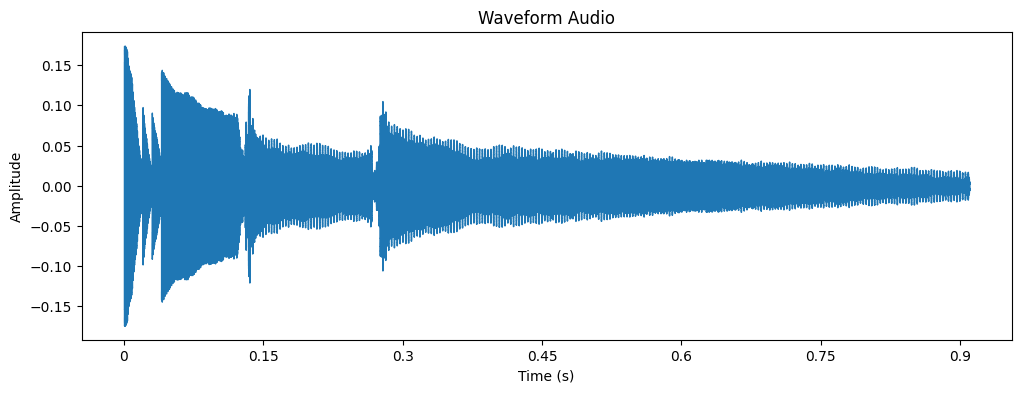

In [66]:
plt.figure(figsize=(12,4))
librosa.display.waveshow(clean_audio, sr=sr)
plt.title("Waveform Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

## Metode FFT (Fast Fourier Transform)

In [67]:
N = len(clean_audio)
fft_spectrum = np.fft.fft(clean_audio)
fft_freq = np.fft.fftfreq(N, 1/sr)
fft_magnitude = np.abs(fft_spectrum)

# Ambil frekuensi positif saja
mask = fft_freq >= 0
fft_freq = fft_freq[mask]
fft_magnitude = fft_magnitude[mask]

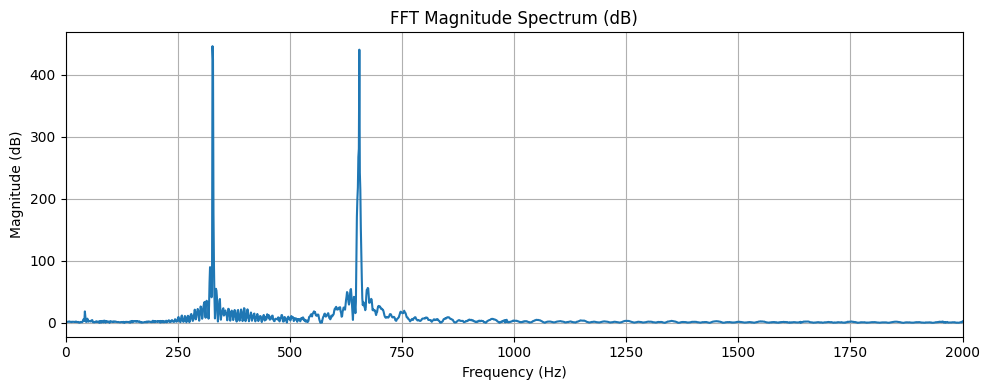

In [68]:
plt.figure(figsize=(10,4))
plt.plot(fft_freq, fft_magnitude)
plt.title("FFT Magnitude Spectrum (dB)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.xlim(0, 2000)
plt.tight_layout()
plt.show()

### Mencari frekuensi dominan dengan FFT

In [69]:
peaks, _ = find_peaks(fft_magnitude, height=np.max(fft_magnitude)*0.2)
dominant_fft_freq = fft_freq[peaks[np.argmax(fft_magnitude[peaks])]]

print("\nDominan Frequency (FFT):", np.round(dominant_fft_freq, 2), "Hz")


Dominan Frequency (FFT): 327.47 Hz


Visualisasi Frekuensi Dominan dengan FFT

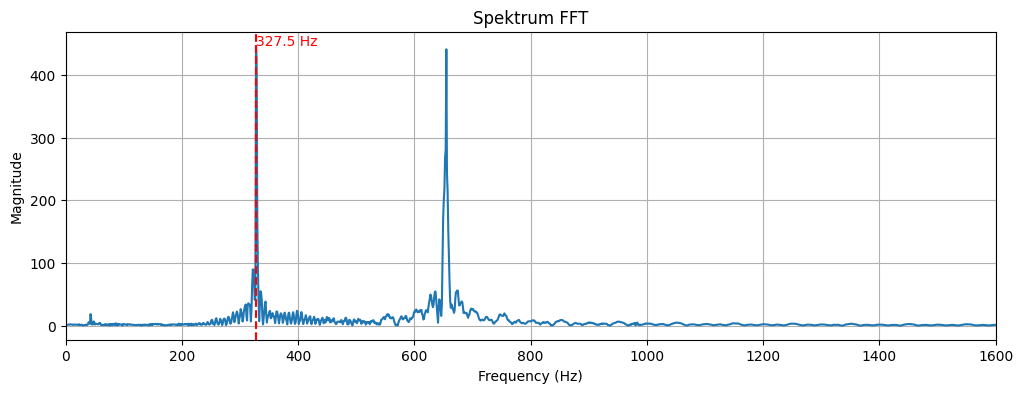

In [70]:
plt.figure(figsize=(12,4))
plt.plot(fft_freq, fft_magnitude)
plt.title("Spektrum FFT")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, sr/30)

# Penanda frekuensi dominan
plt.axvline(dominant_fft_freq, linestyle="--", color="red")
plt.text(dominant_fft_freq,
         np.max(fft_magnitude),
         f"{dominant_fft_freq:.1f} Hz",
         color="red")

plt.grid(True)
plt.show()

## Metode Goertzel (Pencarian frekuensi tertentu)

In [71]:
def goertzel(samples, sample_rate, target_freq):
    n = len(samples)
    k = int(0.5 + ((n * target_freq) / sample_rate))
    w = (2 * np.pi / n) * k
    cosine = np.cos(w)
    sine = np.sin(w)
    coeff = 2 * cosine
    q0, q1, q2 = 0, 0, 0
    for i in range(n):
        q0 = coeff * q1 - q2 + samples[i]
        q2 = q1
        q1 = q0
    real = q1 - q2 * cosine
    imag = q2 * sine

    return real + 1j * imag

In [72]:
# Cek Goertzel pada frekuensi umum audio
target_freqs = [200, 400, 500, 600, 800, 1000, 1500, 2000]

results = []

print("\nAnalisis Frekuensi (Goertzel)")
for f in target_freqs:
    value = goertzel(clean_audio, sr, f)

    mag = np.abs(value) / len(clean_audio)                      
    mag_db = 20 * np.log10(mag + 1e-12)         

    results.append([f, mag, mag_db])

    print(f"{f} Hz : {value}, Mag: {mag:.4f}, dB: {mag_db:.2f}")


Analisis Frekuensi (Goertzel)
200 Hz : (1.2415044503931227+2.7015484983210403j), Mag: 0.0001, dB: -83.34
400 Hz : (8.1506375490778-9.454070391821224j), Mag: 0.0003, dB: -70.88
500 Hz : (4.535576861939489+5.049126596269033j), Mag: 0.0002, dB: -76.17
600 Hz : (10.340252570524513+20.1419634800175j), Mag: 0.0005, dB: -65.71
800 Hz : (-3.3860268941177694-6.2001519853807485j), Mag: 0.0002, dB: -75.82
1000 Hz : (-1.341893301920095-2.8198947509545405j), Mag: 0.0001, dB: -82.91
1500 Hz : (-0.5482784601539228-1.5515188781305562j), Mag: 0.0000, dB: -88.48
2000 Hz : (-1.908713990204669-1.4029416777069998j), Mag: 0.0001, dB: -85.31


In [73]:
df_goertzel = pd.DataFrame(results, columns=["freq", "magnitude_linier", "magnitude_dB"])
freq_dom_goertzel = df_goertzel.loc[df_goertzel["magnitude_linier"].idxmax(), "freq"]
print("\nDataFrame hasil Goertzel:")
print(df_goertzel)


DataFrame hasil Goertzel:
   freq  magnitude_linier  magnitude_dB
0   200          0.000068    -83.341278
1   400          0.000286    -70.879634
2   500          0.000155    -76.171929
3   600          0.000518    -65.707701
4   800          0.000162    -75.824032
5  1000          0.000071    -82.914500
6  1500          0.000038    -88.479454
7  2000          0.000054    -85.314913


Visualisasi Spectrum Goertzel

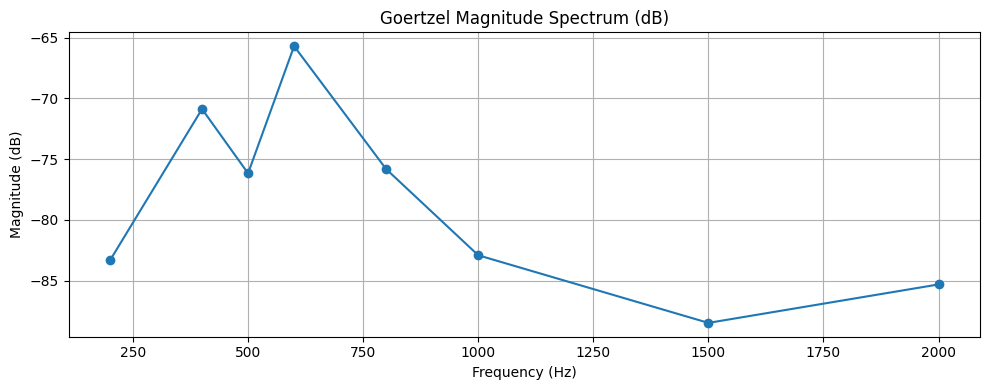

In [74]:
plt.figure(figsize=(10,4))
plt.plot(df_goertzel["freq"], df_goertzel["magnitude_dB"], marker='o')
plt.title("Goertzel Magnitude Spectrum (dB)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Mencari frekuensi dominan dengan Goertzel

In [75]:
dominant_index = np.argmax(df_goertzel["magnitude_dB"])
dominant_freq = df_goertzel.iloc[dominant_index]["freq"]

print("\nFrekuensi Dominan (Goertzel):", dominant_freq, "Hz")


Frekuensi Dominan (Goertzel): 600.0 Hz


Visualisasi Frekuensi Dominan dengan Goertzel

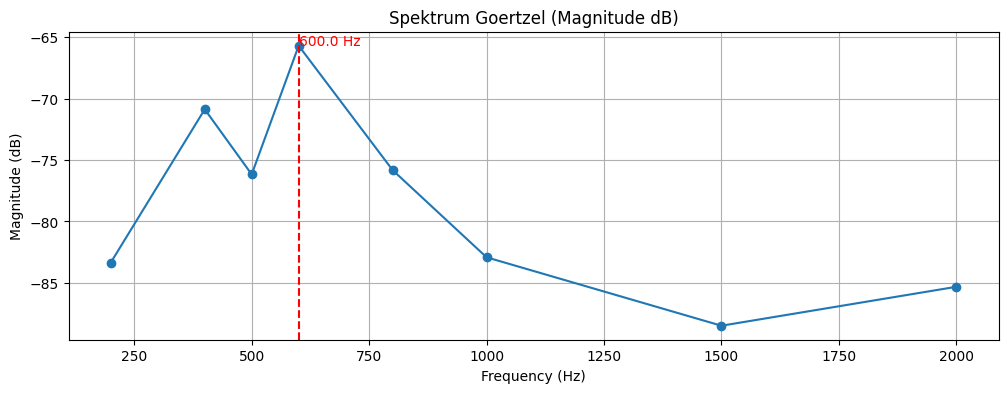

In [76]:
plt.figure(figsize=(12,4))
plt.plot(df_goertzel["freq"], df_goertzel["magnitude_dB"], marker='o')
plt.title("Spektrum Goertzel (Magnitude dB)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)

# gaya anotasi dominan
plt.axvline(dominant_freq, linestyle='--', color='red')
plt.text(dominant_freq,
         df_goertzel["magnitude_dB"].max(),
         f"{dominant_freq:.1f} Hz",
         color='red')

plt.show()

## Perbandingan Frekuensi Dominan pada FFT dan Goertzel

In [77]:
print("Magnitude FFT :", dominant_fft_freq)
print("Magnitude Goertzel :", dominant_freq)

Magnitude FFT : 327.4725274725275
Magnitude Goertzel : 600.0


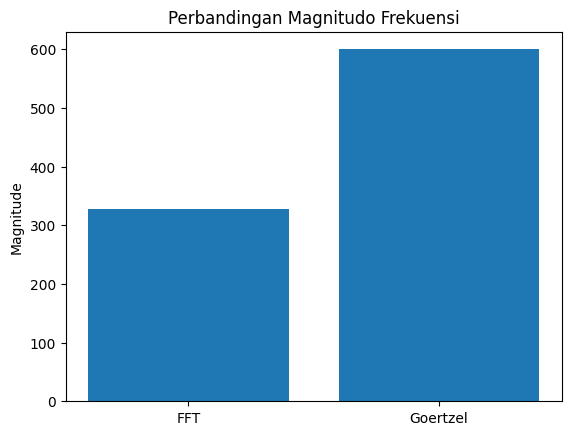

In [78]:
plt.bar(["FFT", "Goertzel"], [dominant_fft_freq, dominant_freq])
plt.ylabel("Magnitude")
plt.title("Perbandingan Magnitudo Frekuensi")
plt.show()

## Penyimpanan perbandingan

In [79]:
hasil_frekdominan = {
    "filename": "signal_baterai",
    "dominant_goertzel": dominant_freq,
    "dominant_fft": dominant_fft_freq
}

df_all = pd.DataFrame([hasil_frekdominan])

nama = hasil_frekdominan["filename"]
df_all.to_csv(f"hasil_{nama}.csv", index=False)
print(f"File tersimpan sebagai hasil_{nama}.csv")


File tersimpan sebagai hasil_signal_baterai.csv
